### Body Segementation MADS - Dataset - Accurancy 90%
#### https://www.kaggle.com/tapakah68/segmentation-full-body-mads-dataset
inspired https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

### Dataset


In [34]:
from torch.utils.data import Dataset
import cv2

In [35]:
class BodyDataset(Dataset):
    def __init__(
            self,
            images_dir,
            masks_dir,
            x_dataset,
            augmentation=None,
            preprocessing=None,
    ):

        self.x_dataset = x_dataset
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.class_values = [0]
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):
        # read data
        image = cv2.imread(os.path.join(
            self.images_dir, self.x_dataset[i]))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(
            self.masks_dir, self.x_dataset[i]))
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.x_dataset)



### Helper

In [52]:
import matplotlib.pyplot as plt

In [36]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20, 8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([])
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_', ' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

### Preprocessing 

In [37]:
import albumentations as albu

In [38]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)


### Dataset location

In [39]:
import os

In [40]:
IMAGES_DIR = './bodies/images/'
MASKS_DIR = './bodies/masks/'
full_dataset = next(os.walk(
    './bodies/images'))[2]


### Define Model

In [41]:
import segmentation_models_pytorch as smp
import torch

In [42]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cpu'


model = smp.DeepLabV3Plus(
    encoder_name=ENCODER,
    encoder_weights= ENCODER_WEIGHTS,
    activation=torch.nn.ReLU,
    classes=1,
    decoder_atrous_rates=(6, 12, 18)
)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### Split Dataset to traindataset, validdataset

In [43]:
from torch.utils.data import random_split

In [50]:
train_size = int(0.8 * len(full_dataset))
valid_size = len(full_dataset) - train_size
train_dataset, valid_dataset = random_split(
    full_dataset, [train_size, valid_size])

### Visualize first data

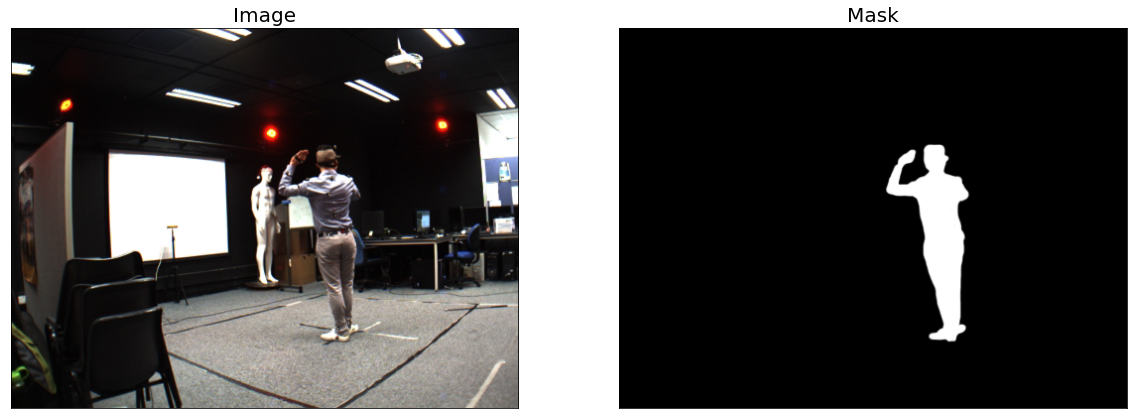

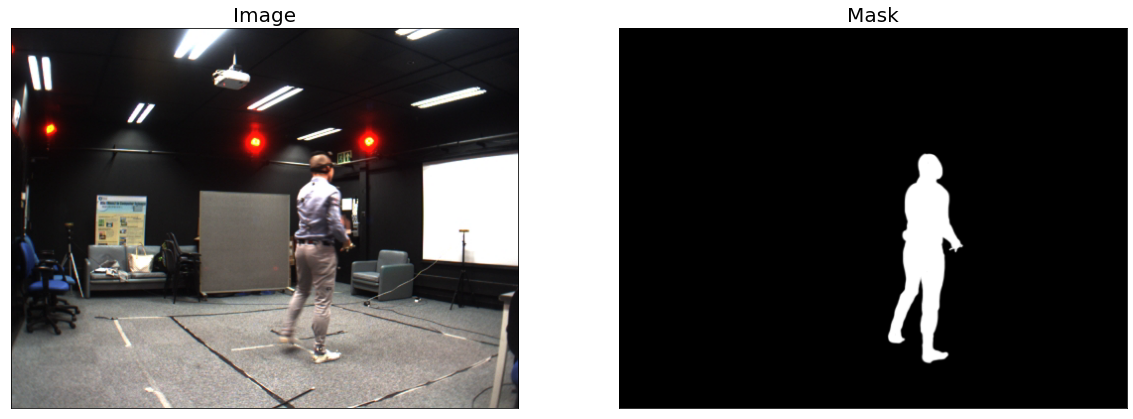

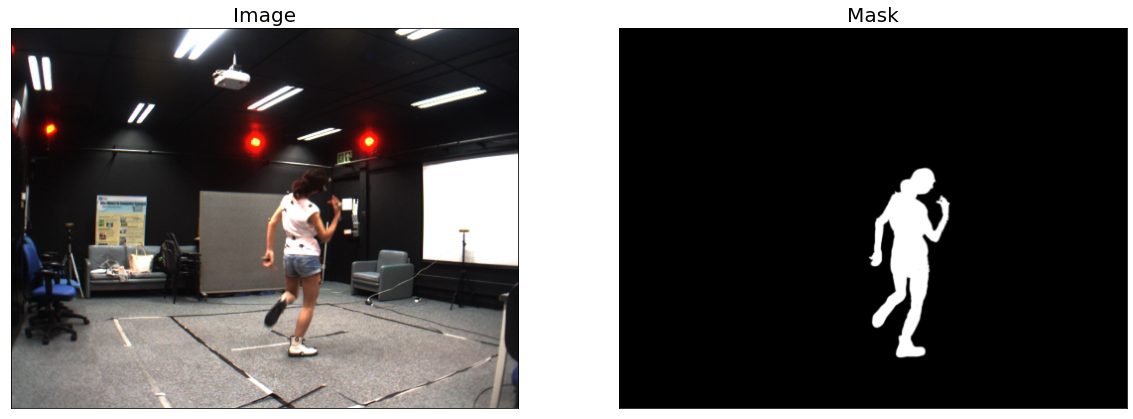

In [53]:
vis_set = BodyDataset(IMAGES_DIR, MASKS_DIR, train_dataset)
for i in range(3):
    img, mask = vis_set[i]
    visualize(image = img, mask=mask)

### Create Dataset & Dataloader

In [45]:
from torch.utils.data import DataLoader

In [48]:
 train_dataset = BodyDataset(IMAGES_DIR, MASKS_DIR,
                            train_dataset, preprocessing=get_preprocessing(preprocessing_fn))


valid_dataset = BodyDataset(IMAGES_DIR, MASKS_DIR,
                            valid_dataset, preprocessing=get_preprocessing(preprocessing_fn))


train_loader = DataLoader(train_dataset, batch_size=15,
                          shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=1,
                          shuffle=False, num_workers=4)

<class 'tuple'>


### Define loss, metrtics, optimizer

In [29]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.Accuracy(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.0001),
])

train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

### Train Model

In [32]:
if __name__ == "__main__":
#     max_score = 0

#     for i in range(0, 8):
#         print('\nEpoch: {}'.format(i))
#     train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)

#     # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(model, './second_best_model.pth')
#         print('Model saved!')

SyntaxError: unexpected EOF while parsing (<ipython-input-32-5afbe032a8f0>, line 13)

### Test Model

In [35]:
    test_dir_imgs = "./bodies/test/images"
    test_dir_masks = "./bodies/test/mask"
    full_testdataset = next(os.walk('./bodies/test/images'))[2]
    test_dataset_withpre = BodyDataset(
        test_dir_imgs, test_dir_masks, full_testdataset, preprocessing=get_preprocessing(preprocessing_fn))
    test_dataset_withoutpre = BodyDataset(
        test_dir_imgs, test_dir_masks, full_testdataset)
    best_model = torch.load('./best_model.pth')
    test_loader = DataLoader(test_dataset_withpre, batch_size=1,
                             shuffle=False, num_workers=2)
    test_epoch = smp.utils.train.ValidEpoch(
        model=best_model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )
#     logs = test_epoch.run(test_loader)

### Visualize Data

In [37]:
import numpy as np

In [36]:
    for i in range(5):
        n = np.random.choice(len(test_dataset_withpre))
        image_vis = test_dataset_withpre[n][0].astype('uint8')
        image, gt_mask = test_dataset_withpre[n]

        gt_mask = gt_mask.squeeze()
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        pr_mask = best_model.predict(x_tensor)
        pr_mask = (pr_mask.squeeze().cpu().numpy().round())

        image, mask = test_dataset_withoutpre[n]

        visualize(
            image=image,
            ground_truth_mask=mask,
            predicted_mask=pr_mask
        )

NameError: name 'np' is not defined

![title](train_results/res1.png)
![title](train_results/res2.png)
![title](train_results/res3.png)
![title](train_results/res4.png)
![title](train_results/res5.png)